In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v7 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-19 14:52:18.481795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:18.482415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:18.538736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:18.539133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:18.539369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_043'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

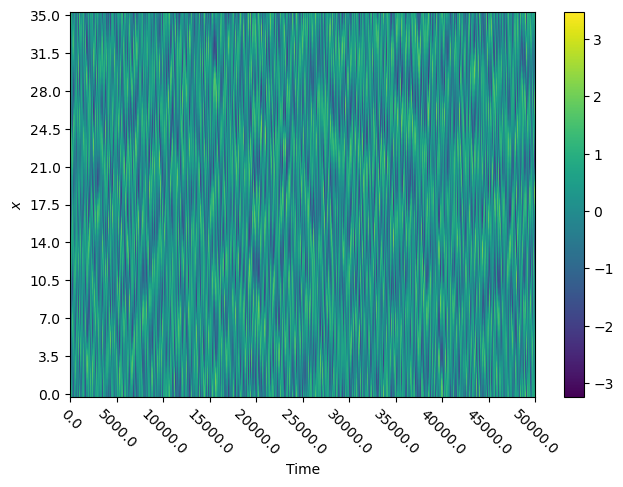

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([10, 15, 20])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [1e-5],
        [2e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 9.1382e-04 - global_gradnorm: 2.0828 - tot_time: 0h 0m 55.8s

Epoch 1: val_NMSE improved from inf to 0.01170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoi

71/71 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 6.7597e-04 - global_gradnorm: 1.1977 - tot_time: 0h 5m 16.5s

Epoch 11: val_NMSE improved from 0.00859 to 0.00846, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0115 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 6.7626e-04 - global_gradnorm: 1.1967 - val_loss: 0.0109 - val_mse: 9.4054e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0113 - mse: 9.9827e-04 - NMSE: 0.0090 - covmat_fro_loss: 6.6785e-04 - global_gradnorm: 1.1684 - tot_time: 0h 5m 42.5s

Epoch 12: val_NMSE did not i

71/71 [==============================] - ETA: 0s - loss: 0.0097 - mse: 8.0807e-04 - NMSE: 0.0073 - covmat_fro_loss: 6.0625e-04 - global_gradnorm: 0.8915 - tot_time: 0h 10m 2.8s

Epoch 22: val_NMSE improved from 0.00706 to 0.00653, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 375ms/step - loss: 0.0097 - mse: 8.0807e-04 - NMSE: 0.0073 - covmat_fro_loss: 6.0615e-04 - global_gradnorm: 0.8925 - val_loss: 0.0090 - val_mse: 7.2549e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/1000
71/71 [==============================] - ETA: 0s - loss: 0.0096 - mse: 8.0555e-04 - NMSE: 0.0072 - covmat_fro_loss: 6.0467e-04 - global_gradnorm: 0.8818 - tot_time: 0h 10m 28.8s

Epoch 23: val_NMSE 

Epoch 34/1000
71/71 [==============================] - ETA: 0s - loss: 0.0088 - mse: 7.2208e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.7636e-04 - global_gradnorm: 0.7938 - tot_time: 0h 15m 13.9s

Epoch 34: val_NMSE did not improve from 0.00612
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - loss: 0.0088 - mse: 7.2208e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.7634e-04 - global_gradnorm: 0.7933 - val_loss: 0.0090 - val_mse: 7.4398e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 35/1000
71/71 [==============================] - ETA: 0s - loss: 0.0090 - mse: 7.4141e-04 - NMSE: 0.0067 - covmat_fro_loss: 5.8433e-04 - global_gradnorm: 0.8346 - tot_time: 0h 15m 40.1s

Epoch 35: val_NMSE did not improve from 0.00612
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 46/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 6.7294e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.5772e-04 - global_gradnorm: 0.7641 - tot_time: 0h 20m 25.6s

Epoch 46: val_NMSE did not improve from 0.00590
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0083 - mse: 6.7294e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.5766e-04 - global_gradnorm: 0.7652 - val_loss: 0.0086 - val_mse: 7.0511e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 6.7146e-04 - NMSE: 0.0060 - covmat_fro_loss: 5.5752e-04 - global_gradnorm: 0.7838 - tot_time: 0h 20m 51.5s

Epoch 47: val_NMSE did not improve from 0.00590
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0077 - mse: 6.1174e-04 - NMSE: 0.0055 - covmat_fro_loss: 5.3310e-04 - global_gradnorm: 0.7106 - val_loss: 0.0076 - val_mse: 5.9745e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 58/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 5.9900e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.2699e-04 - global_gradnorm: 0.6708 - tot_time: 0h 25m 36.8s

Epoch 58: val_NMSE did not improve from 0.00538
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 372ms/step - loss: 0.0076 - mse: 5.9900e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.2711e-04 - global_gradnorm: 0.6724 - val_loss: 0.008

71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 5.8421e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.2148e-04 - global_gradnorm: 0.6500 - tot_time: 0h 30m 22.1s

Epoch 69: val_NMSE did not improve from 0.00514
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - loss: 0.0074 - mse: 5.8421e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.2141e-04 - global_gradnorm: 0.6494 - val_loss: 0.0082 - val_mse: 6.7907e-04 - val_NMSE: 0.0061 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 70/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 5.8844e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.2317e-04 - global_gradnorm: 0.6710 - tot_time: 0h 30m 48.1s

Epoch 70: val_NMSE did not improve from 0.00514
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 81/1000
71/71 [==============================] - ETA: 0s - loss: 0.0070 - mse: 5.4218e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.0321e-04 - global_gradnorm: 0.6270 - tot_time: 0h 35m 32.4s

Epoch 81: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0070 - mse: 5.4218e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.0295e-04 - global_gradnorm: 0.6261 - val_loss: 0.0072 - val_mse: 5.6170e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 82/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 5.4881e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.0600e-04 - global_gradnorm: 0.6541 - tot_time: 0h 35m 58.4s

Epoch 82: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 93/1000
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 4.8996e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7785e-04 - global_gradnorm: 0.5483 - tot_time: 0h 40m 42.1s

Epoch 93: val_NMSE did not improve from 0.00455
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 369ms/step - loss: 0.0065 - mse: 4.8996e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7710e-04 - global_gradnorm: 0.5471 - val_loss: 0.0067 - val_mse: 5.0955e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 94/1000
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 4.8992e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7853e-04 - global_gradnorm: 0.5322 - tot_time: 0h 41m 7.8s

Epoch 94: val_NMSE did not improve from 0.00455
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 105/1000
71/71 [==============================] - ETA: 0s - loss: 0.0066 - mse: 5.0040e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.8235e-04 - global_gradnorm: 0.5685 - tot_time: 0h 45m 53.2s

Epoch 105: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 368ms/step - loss: 0.0066 - mse: 5.0040e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.8254e-04 - global_gradnorm: 0.5685 - val_loss: 0.0069 - val_mse: 5.4246e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 106/1000
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 4.8716e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7805e-04 - global_gradnorm: 0.5570 - tot_time: 0h 46m 18.9s

Epoch 106: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 117/1000
71/71 [==============================] - ETA: 0s - loss: 0.0062 - mse: 4.5980e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6338e-04 - global_gradnorm: 0.5444 - tot_time: 0h 51m 4.7s

Epoch 117: val_NMSE did not improve from 0.00423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0062 - mse: 4.5980e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6317e-04 - global_gradnorm: 0.5426 - val_loss: 0.0066 - val_mse: 5.0941e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 118/1000
71/71 [==============================] - ETA: 0s - loss: 0.0063 - mse: 4.7575e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.7159e-04 - global_gradnorm: 0.5673 - tot_time: 0h 51m 30.0s

Epoch 118: val_NMSE did not improve from 0.00423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 129/1000
71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.1595e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.4110e-04 - global_gradnorm: 0.4711 - tot_time: 0h 56m 14.7s

Epoch 129: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0058 - mse: 4.1595e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.4089e-04 - global_gradnorm: 0.4703 - val_loss: 0.0060 - val_mse: 4.3473e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 130/1000
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 4.3715e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5268e-04 - global_gradnorm: 0.4997 - tot_time: 0h 56m 40.8s

Epoch 130: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.1461e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3959e-04 - global_gradnorm: 0.4645 - tot_time: 1h 1m 25.1s

Epoch 141: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0058 - mse: 4.1461e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3968e-04 - global_gradnorm: 0.4658 - val_loss: 0.0063 - val_mse: 4.7623e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 142/1000
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 3.9742e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2941e-04 - global_gradnorm: 0.4429 - tot_time: 1h 1m 51.1s

Epoch 142: val_NMSE did not improve from 0.00373
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 153/1000
71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 3.9915e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3167e-04 - global_gradnorm: 0.4615 - tot_time: 1h 6m 34.7s

Epoch 153: val_NMSE improved from 0.00366 to 0.00365, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0056 - mse: 3.9915e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3181e-04 - global_gradnorm: 0.4618 - val_loss: 0.0057 - val_mse: 4.0595e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 154/1000
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.0601e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3462e-04 - global_gradnorm: 0.4596 - tot_time: 1h 7m 1.2s

Epoc

Epoch 165/1000
71/71 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.7793e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2048e-04 - global_gradnorm: 0.4159 - tot_time: 1h 11m 46.4s

Epoch 165: val_NMSE did not improve from 0.00356
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0054 - mse: 3.7793e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2009e-04 - global_gradnorm: 0.4156 - val_loss: 0.0056 - val_mse: 4.0020e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 166/1000
71/71 [==============================] - ETA: 0s - loss: 0.0055 - mse: 3.8874e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2561e-04 - global_gradnorm: 0.4555 - tot_time: 1h 12m 12.2s

Epoch 166: val_NMSE did not improve from 0.00356
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 177/1000
71/71 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.7997e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2031e-04 - global_gradnorm: 0.4374 - tot_time: 1h 16m 58.3s

Epoch 177: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0054 - mse: 3.7997e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2036e-04 - global_gradnorm: 0.4379 - val_loss: 0.0057 - val_mse: 4.1217e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 178/1000
71/71 [==============================] - ETA: 0s - loss: 0.0055 - mse: 3.8669e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2454e-04 - global_gradnorm: 0.4433 - tot_time: 1h 17m 23.8s

Epoch 178: val_NMSE did not improve from 0.00347
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 189/1000
71/71 [==============================] - ETA: 0s - loss: 0.0053 - mse: 3.5994e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0829e-04 - global_gradnorm: 0.4112 - tot_time: 1h 22m 7.6s

Epoch 189: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 367ms/step - loss: 0.0053 - mse: 3.5994e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0836e-04 - global_gradnorm: 0.4117 - val_loss: 0.0057 - val_mse: 4.1061e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 190/1000
71/71 [==============================] - ETA: 0s - loss: 0.0055 - mse: 3.9028e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2668e-04 - global_gradnorm: 0.4375 - tot_time: 1h 22m 33.3s

Epoch 190: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 201/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.6009e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0842e-04 - global_gradnorm: 0.4158 - tot_time: 1h 27m 17.3s

Epoch 201: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0052 - mse: 3.6009e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0894e-04 - global_gradnorm: 0.4164 - val_loss: 0.0056 - val_mse: 4.0593e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 202/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.6071e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0866e-04 - global_gradnorm: 0.4132 - tot_time: 1h 27m 42.7s

Epoch 202: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 213/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.6499e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1178e-04 - global_gradnorm: 0.4245 - tot_time: 1h 32m 28.4s

Epoch 213: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - loss: 0.0052 - mse: 3.6499e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1152e-04 - global_gradnorm: 0.4240 - val_loss: 0.0053 - val_mse: 3.6631e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 214/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.5769e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0800e-04 - global_gradnorm: 0.4034 - tot_time: 1h 32m 54.1s

Epoch 214: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0050 - mse: 3.3981e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9690e-04 - global_gradnorm: 0.3855 - tot_time: 1h 37m 38.4s

Epoch 225: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0050 - mse: 3.3981e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9740e-04 - global_gradnorm: 0.3851 - val_loss: 0.0054 - val_mse: 3.8252e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 226/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.6387e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1288e-04 - global_gradnorm: 0.4269 - tot_time: 1h 38m 4.1s

Epoch 226: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

71/71 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.5440e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0379e-04 - global_gradnorm: 0.4132 - tot_time: 1h 42m 48.0s

Epoch 237: val_NMSE improved from 0.00308 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 372ms/step - loss: 0.0051 - mse: 3.5440e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0354e-04 - global_gradnorm: 0.4129 - val_loss: 0.0050 - val_mse: 3.3863e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 238/1000
71/71 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.4641e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0085e-04 - global_gradnorm: 0.3908 - tot_time: 1h 43m 14.2s

Epoch 238: val_N

Epoch 249/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 3.2274e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8613e-04 - global_gradnorm: 0.3731 - tot_time: 1h 47m 58.1s

Epoch 249: val_NMSE improved from 0.00300 to 0.00300, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 371ms/step - loss: 0.0048 - mse: 3.2274e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8611e-04 - global_gradnorm: 0.3727 - val_loss: 0.0049 - val_mse: 3.3309e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 250/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 3.1913e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8448e-04 - global_gradnorm: 0.3602 - tot_time: 1h 48m 24.2s

E

Epoch 261/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 3.1766e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8373e-04 - global_gradnorm: 0.3542 - tot_time: 1h 53m 9.2s

Epoch 261: val_NMSE did not improve from 0.00299
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0048 - mse: 3.1766e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8359e-04 - global_gradnorm: 0.3543 - val_loss: 0.0050 - val_mse: 3.3820e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 262/1000
71/71 [==============================] - ETA: 0s - loss: 0.0049 - mse: 3.3554e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9496e-04 - global_gradnorm: 0.3877 - tot_time: 1h 53m 35.0s

Epoch 262: val_NMSE did not improve from 0.00299
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 273/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 3.0357e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7420e-04 - global_gradnorm: 0.3380 - tot_time: 1h 58m 20.0s

Epoch 273: val_NMSE improved from 0.00294 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 370ms/step - loss: 0.0047 - mse: 3.0357e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7497e-04 - global_gradnorm: 0.3376 - val_loss: 0.0048 - val_mse: 3.1452e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 274/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 3.0416e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7396e-04 - global_gradnorm: 0.3467 - tot_time: 1h 58m 46.2s

E

Epoch 285/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 3.0672e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7671e-04 - global_gradnorm: 0.3497 - tot_time: 2h 3m 31.6s

Epoch 285: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 359ms/step - loss: 0.0047 - mse: 3.0672e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7623e-04 - global_gradnorm: 0.3484 - val_loss: 0.0048 - val_mse: 3.2879e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 286/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 3.0343e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7443e-04 - global_gradnorm: 0.3511 - tot_time: 2h 3m 57.9s

Epoch 286: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 297/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 3.0295e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7375e-04 - global_gradnorm: 0.3361 - tot_time: 2h 8m 42.3s

Epoch 297: val_NMSE improved from 0.00268 to 0.00266, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 369ms/step - loss: 0.0046 - mse: 3.0295e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7353e-04 - global_gradnorm: 0.3361 - val_loss: 0.0046 - val_mse: 2.9578e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 298/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.9485e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6817e-04 - global_gradnorm: 0.3323 - tot_time: 2h 9m 8.7s

Epoc

Epoch 309/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.9972e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7201e-04 - global_gradnorm: 0.3584 - tot_time: 2h 13m 50.7s

Epoch 309: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 355ms/step - loss: 0.0046 - mse: 2.9972e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7206e-04 - global_gradnorm: 0.3581 - val_loss: 0.0048 - val_mse: 3.3339e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 310/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.8992e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6525e-04 - global_gradnorm: 0.3299 - tot_time: 2h 14m 16.2s

Epoch 310: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 321/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 3.0238e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7306e-04 - global_gradnorm: 0.3501 - tot_time: 2h 18m 54.6s

Epoch 321: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 352ms/step - loss: 0.0046 - mse: 3.0238e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7296e-04 - global_gradnorm: 0.3495 - val_loss: 0.0046 - val_mse: 3.0404e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 322/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 3.0188e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7363e-04 - global_gradnorm: 0.3461 - tot_time: 2h 19m 19.7s

Epoch 322: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.8450e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6239e-04 - global_gradnorm: 0.3241 - tot_time: 2h 23m 58.4s

Epoch 333: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0044 - mse: 2.8450e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6275e-04 - global_gradnorm: 0.3247 - val_loss: 0.0046 - val_mse: 3.1279e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 334/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.8378e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6092e-04 - global_gradnorm: 0.3281 - tot_time: 2h 24m 22.4s

Epoch 334: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 345/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.8193e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5982e-04 - global_gradnorm: 0.3249 - tot_time: 2h 29m 2.7s

Epoch 345: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0044 - mse: 2.8193e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6002e-04 - global_gradnorm: 0.3251 - val_loss: 0.0046 - val_mse: 3.0747e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 346/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.7992e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5858e-04 - global_gradnorm: 0.3130 - tot_time: 2h 29m 28.7s

Epoch 346: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 357/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.9168e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6644e-04 - global_gradnorm: 0.3435 - tot_time: 2h 34m 13.1s

Epoch 357: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0044 - mse: 2.9168e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6649e-04 - global_gradnorm: 0.3433 - val_loss: 0.0045 - val_mse: 2.9946e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 358/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.8199e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.6003e-04 - global_gradnorm: 0.3214 - tot_time: 2h 34m 38.7s

Epoch 358: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 369/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.7161e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5253e-04 - global_gradnorm: 0.3142 - tot_time: 2h 39m 12.4s

Epoch 369: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0042 - mse: 2.7161e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5268e-04 - global_gradnorm: 0.3135 - val_loss: 0.0046 - val_mse: 3.1631e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 370/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.6859e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5069e-04 - global_gradnorm: 0.3067 - tot_time: 2h 39m 37.6s

Epoch 370: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.7636e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5506e-04 - global_gradnorm: 0.3002 - tot_time: 2h 44m 15.9s

Epoch 381: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 355ms/step - loss: 0.0043 - mse: 2.7636e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5488e-04 - global_gradnorm: 0.3003 - val_loss: 0.0042 - val_mse: 2.7110e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 382/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.7206e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5303e-04 - global_gradnorm: 0.3107 - tot_time: 2h 44m 41.3s

Epoch 382: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 393/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.6915e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5057e-04 - global_gradnorm: 0.3000 - tot_time: 2h 49m 18.9s

Epoch 393: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 353ms/step - loss: 0.0042 - mse: 2.6915e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.5087e-04 - global_gradnorm: 0.3006 - val_loss: 0.0045 - val_mse: 3.0659e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 394/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.6231e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4625e-04 - global_gradnorm: 0.2985 - tot_time: 2h 49m 44.3s

Epoch 394: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.5842e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4342e-04 - global_gradnorm: 0.2945 - tot_time: 2h 54m 16.5s

Epoch 405: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0041 - mse: 2.5842e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4386e-04 - global_gradnorm: 0.2948 - val_loss: 0.0043 - val_mse: 2.8380e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 406/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.6174e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4642e-04 - global_gradnorm: 0.2964 - tot_time: 2h 54m 40.4s

Epoch 406: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 417/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.5578e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4146e-04 - global_gradnorm: 0.2773 - tot_time: 2h 59m 8.3s

Epoch 417: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0041 - mse: 2.5578e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4163e-04 - global_gradnorm: 0.2780 - val_loss: 0.0047 - val_mse: 3.2942e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 418/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.6695e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4943e-04 - global_gradnorm: 0.2977 - tot_time: 2h 59m 32.6s

Epoch 418: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 429/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.4970e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3724e-04 - global_gradnorm: 0.2768 - tot_time: 3h 4m 0.5s

Epoch 429: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 345ms/step - loss: 0.0040 - mse: 2.4970e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3735e-04 - global_gradnorm: 0.2775 - val_loss: 0.0041 - val_mse: 2.6643e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 430/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.5502e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3937e-04 - global_gradnorm: 0.2779 - tot_time: 3h 4m 24.8s

Epoch 430: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.5060e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3657e-04 - global_gradnorm: 0.2754 - tot_time: 3h 8m 47.2s

Epoch 441: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 334ms/step - loss: 0.0040 - mse: 2.5060e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3670e-04 - global_gradnorm: 0.2756 - val_loss: 0.0042 - val_mse: 2.7076e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 442/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.6294e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4605e-04 - global_gradnorm: 0.2931 - tot_time: 3h 9m 11.5s

Epoch 442: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.5387e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3900e-04 - global_gradnorm: 0.2853 - tot_time: 3h 13m 35.5s

Epoch 453: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0040 - mse: 2.5387e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3891e-04 - global_gradnorm: 0.2858 - val_loss: 0.0040 - val_mse: 2.5407e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 454/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.5622e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4198e-04 - global_gradnorm: 0.2848 - tot_time: 3h 14m 0.0s

Epoch 454: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 465/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.4653e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3472e-04 - global_gradnorm: 0.2699 - tot_time: 3h 18m 22.7s

Epoch 465: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 334ms/step - loss: 0.0039 - mse: 2.4653e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3444e-04 - global_gradnorm: 0.2697 - val_loss: 0.0040 - val_mse: 2.5955e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 466/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.4263e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3029e-04 - global_gradnorm: 0.2640 - tot_time: 3h 18m 46.6s

Epoch 466: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3556e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2615e-04 - global_gradnorm: 0.2504 - tot_time: 3h 23m 9.7s

Epoch 477: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 346ms/step - loss: 0.0038 - mse: 2.3556e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2629e-04 - global_gradnorm: 0.2507 - val_loss: 0.0041 - val_mse: 2.6562e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 478/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3341e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2454e-04 - global_gradnorm: 0.2561 - tot_time: 3h 23m 33.5s

Epoch 478: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 489/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3304e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2392e-04 - global_gradnorm: 0.2605 - tot_time: 3h 27m 55.8s

Epoch 489: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 336ms/step - loss: 0.0038 - mse: 2.3304e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2387e-04 - global_gradnorm: 0.2603 - val_loss: 0.0040 - val_mse: 2.5398e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 490/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3270e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2408e-04 - global_gradnorm: 0.2486 - tot_time: 3h 28m 19.6s

Epoch 490: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 501/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.4153e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3037e-04 - global_gradnorm: 0.2627 - tot_time: 3h 32m 43.1s

Epoch 501: val_NMSE improved from 0.00214 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 344ms/step - loss: 0.0038 - mse: 2.4153e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3033e-04 - global_gradnorm: 0.2630 - val_loss: 0.0038 - val_mse: 2.3520e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 502/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3116e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2357e-04 - global_gradnorm: 0.2546 - tot_time: 3h 33m 7.6s

Ep

Epoch 513/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3730e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2747e-04 - global_gradnorm: 0.2500 - tot_time: 3h 37m 30.9s

Epoch 513: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0038 - mse: 2.3730e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2787e-04 - global_gradnorm: 0.2506 - val_loss: 0.0039 - val_mse: 2.5401e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 514/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3283e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2356e-04 - global_gradnorm: 0.2503 - tot_time: 3h 37m 54.8s

Epoch 514: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 525/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.4160e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3062e-04 - global_gradnorm: 0.2608 - tot_time: 3h 42m 19.7s

Epoch 525: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0038 - mse: 2.4160e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3064e-04 - global_gradnorm: 0.2610 - val_loss: 0.0039 - val_mse: 2.5539e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 526/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.5008e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3733e-04 - global_gradnorm: 0.2740 - tot_time: 3h 42m 43.6s

Epoch 526: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 537/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.3413e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2449e-04 - global_gradnorm: 0.2433 - tot_time: 3h 47m 8.7s

Epoch 537: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 334ms/step - loss: 0.0037 - mse: 2.3413e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2479e-04 - global_gradnorm: 0.2434 - val_loss: 0.0039 - val_mse: 2.4760e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 538/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.4409e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3340e-04 - global_gradnorm: 0.2628 - tot_time: 3h 47m 32.8s

Epoch 538: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.3832e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2758e-04 - global_gradnorm: 0.2669 - tot_time: 3h 51m 57.0s

Epoch 549: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 336ms/step - loss: 0.0038 - mse: 2.3832e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2770e-04 - global_gradnorm: 0.2673 - val_loss: 0.0039 - val_mse: 2.5496e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 550/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.4030e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2932e-04 - global_gradnorm: 0.2651 - tot_time: 3h 52m 21.1s

Epoch 550: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 561/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.2849e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2105e-04 - global_gradnorm: 0.2475 - tot_time: 3h 56m 46.4s

Epoch 561: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0037 - mse: 2.2849e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2082e-04 - global_gradnorm: 0.2475 - val_loss: 0.0038 - val_mse: 2.4768e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 562/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.2394e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1779e-04 - global_gradnorm: 0.2434 - tot_time: 3h 57m 10.2s

Epoch 562: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 573/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.2754e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1899e-04 - global_gradnorm: 0.2552 - tot_time: 4h 1m 34.0s

Epoch 573: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0036 - mse: 2.2754e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1876e-04 - global_gradnorm: 0.2550 - val_loss: 0.0039 - val_mse: 2.5626e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 574/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.2254e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1626e-04 - global_gradnorm: 0.2403 - tot_time: 4h 1m 57.8s

Epoch 574: val_NMSE improved from 0.00202 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 585/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.3000e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2079e-04 - global_gradnorm: 0.2443 - tot_time: 4h 6m 20.4s

Epoch 585: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 331ms/step - loss: 0.0036 - mse: 2.3000e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2056e-04 - global_gradnorm: 0.2434 - val_loss: 0.0040 - val_mse: 2.6783e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 586/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.3897e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2956e-04 - global_gradnorm: 0.2653 - tot_time: 4h 6m 44.2s

Epoch 586: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 597/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.3110e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2257e-04 - global_gradnorm: 0.2457 - tot_time: 4h 11m 8.7s

Epoch 597: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 341ms/step - loss: 0.0036 - mse: 2.3110e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2298e-04 - global_gradnorm: 0.2464 - val_loss: 0.0039 - val_mse: 2.5612e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 598/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.2643e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1928e-04 - global_gradnorm: 0.2486 - tot_time: 4h 11m 32.7s

Epoch 598: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.3606e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2577e-04 - global_gradnorm: 0.2670 - tot_time: 4h 15m 57.7s

Epoch 609: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0037 - mse: 2.3606e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2567e-04 - global_gradnorm: 0.2668 - val_loss: 0.0036 - val_mse: 2.2255e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 610/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.1800e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1265e-04 - global_gradnorm: 0.2289 - tot_time: 4h 16m 21.9s

Epoch 610: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.2107e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1551e-04 - global_gradnorm: 0.2357 - tot_time: 4h 20m 47.1s

Epoch 621: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 343ms/step - loss: 0.0035 - mse: 2.2107e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1542e-04 - global_gradnorm: 0.2354 - val_loss: 0.0036 - val_mse: 2.3245e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 622/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.1260e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0712e-04 - global_gradnorm: 0.2269 - tot_time: 4h 21m 10.8s

Epoch 622: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.2449e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1653e-04 - global_gradnorm: 0.2358 - tot_time: 4h 25m 35.1s

Epoch 633: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 339ms/step - loss: 0.0036 - mse: 2.2449e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1700e-04 - global_gradnorm: 0.2366 - val_loss: 0.0039 - val_mse: 2.6791e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 634/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.3991e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2820e-04 - global_gradnorm: 0.2651 - tot_time: 4h 25m 59.2s

Epoch 634: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 645/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.1524e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1053e-04 - global_gradnorm: 0.2375 - tot_time: 4h 30m 23.8s

Epoch 645: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0035 - mse: 2.1524e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1060e-04 - global_gradnorm: 0.2375 - val_loss: 0.0036 - val_mse: 2.3027e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 646/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.1292e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0816e-04 - global_gradnorm: 0.2217 - tot_time: 4h 30m 47.5s

Epoch 646: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.0650e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0230e-04 - global_gradnorm: 0.2103 - tot_time: 4h 35m 10.6s

Epoch 657: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 334ms/step - loss: 0.0034 - mse: 2.0650e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0212e-04 - global_gradnorm: 0.2102 - val_loss: 0.0035 - val_mse: 2.2067e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 658/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.0752e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0355e-04 - global_gradnorm: 0.2117 - tot_time: 4h 35m 34.3s

Epoch 658: val_NMSE improved from 0.00192 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/ch

Epoch 669/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.1625e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1058e-04 - global_gradnorm: 0.2238 - tot_time: 4h 39m 58.6s

Epoch 669: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0035 - mse: 2.1625e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1095e-04 - global_gradnorm: 0.2239 - val_loss: 0.0035 - val_mse: 2.2408e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 670/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.0902e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0463e-04 - global_gradnorm: 0.2242 - tot_time: 4h 40m 22.3s

Epoch 670: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.2163e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1533e-04 - global_gradnorm: 0.2360 - tot_time: 4h 44m 46.3s

Epoch 681: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 335ms/step - loss: 0.0035 - mse: 2.2163e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1511e-04 - global_gradnorm: 0.2354 - val_loss: 0.0037 - val_mse: 2.4935e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 682/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.1142e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0725e-04 - global_gradnorm: 0.2209 - tot_time: 4h 45m 10.0s

Epoch 682: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.1101e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0652e-04 - global_gradnorm: 0.2285 - tot_time: 4h 49m 33.3s

Epoch 693: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 334ms/step - loss: 0.0034 - mse: 2.1101e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0618e-04 - global_gradnorm: 0.2279 - val_loss: 0.0034 - val_mse: 2.1325e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 694/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0163e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9861e-04 - global_gradnorm: 0.2008 - tot_time: 4h 49m 57.3s

Epoch 694: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0503e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0160e-04 - global_gradnorm: 0.2127 - tot_time: 4h 54m 22.2s

Epoch 705: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0033 - mse: 2.0503e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0146e-04 - global_gradnorm: 0.2131 - val_loss: 0.0034 - val_mse: 2.1026e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 706/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0203e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9869e-04 - global_gradnorm: 0.2094 - tot_time: 4h 54m 45.8s

Epoch 706: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0492e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0153e-04 - global_gradnorm: 0.2087 - tot_time: 4h 59m 11.2s

Epoch 717: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0033 - mse: 2.0492e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0153e-04 - global_gradnorm: 0.2087 - val_loss: 0.0036 - val_mse: 2.3444e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 718/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0437e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0130e-04 - global_gradnorm: 0.2109 - tot_time: 4h 59m 35.5s

Epoch 718: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0756e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0461e-04 - global_gradnorm: 0.2129 - tot_time: 5h 4m 1.7s

Epoch 729: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 341ms/step - loss: 0.0033 - mse: 2.0756e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0467e-04 - global_gradnorm: 0.2125 - val_loss: 0.0035 - val_mse: 2.2429e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 730/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0977e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0519e-04 - global_gradnorm: 0.2118 - tot_time: 5h 4m 25.7s

Epoch 730: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9634e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9361e-04 - global_gradnorm: 0.2001 - tot_time: 5h 8m 52.5s

Epoch 741: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0032 - mse: 1.9634e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9313e-04 - global_gradnorm: 0.1995 - val_loss: 0.0034 - val_mse: 2.1246e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 742/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.8936e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8760e-04 - global_gradnorm: 0.1894 - tot_time: 5h 9m 16.9s

Epoch 742: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 753/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.1296e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0840e-04 - global_gradnorm: 0.2271 - tot_time: 5h 13m 42.1s

Epoch 753: val_NMSE did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0034 - mse: 2.1296e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.0839e-04 - global_gradnorm: 0.2268 - val_loss: 0.0034 - val_mse: 2.1164e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 754/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0458e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0114e-04 - global_gradnorm: 0.1977 - tot_time: 5h 14m 6.0s

Epoch 754: val_NMSE did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0378e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0081e-04 - global_gradnorm: 0.2084 - tot_time: 5h 18m 30.4s

Epoch 765: val_NMSE did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 333ms/step - loss: 0.0033 - mse: 2.0378e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0069e-04 - global_gradnorm: 0.2084 - val_loss: 0.0033 - val_mse: 2.0034e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 766/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9751e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9542e-04 - global_gradnorm: 0.2021 - tot_time: 5h 18m 54.3s

Epoch 766: val_NMSE did not improve from 0.00179
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 777/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.0448e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0239e-04 - global_gradnorm: 0.2189 - tot_time: 5h 23m 17.3s

Epoch 777: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0033 - mse: 2.0448e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0211e-04 - global_gradnorm: 0.2190 - val_loss: 0.0033 - val_mse: 2.0395e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 778/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9472e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9253e-04 - global_gradnorm: 0.1936 - tot_time: 5h 23m 41.1s

Epoch 778: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9553e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9387e-04 - global_gradnorm: 0.1982 - tot_time: 5h 28m 5.7s

Epoch 789: val_NMSE improved from 0.00176 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0032 - mse: 1.9553e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9397e-04 - global_gradnorm: 0.1980 - val_loss: 0.0032 - val_mse: 1.9359e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 790/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.0034e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9742e-04 - global_gradnorm: 0.1935 - tot_time: 5h 28m 30.1s

Epoch 790: val_NM

Epoch 801/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9863e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9653e-04 - global_gradnorm: 0.1956 - tot_time: 5h 32m 54.3s

Epoch 801: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 336ms/step - loss: 0.0032 - mse: 1.9863e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9656e-04 - global_gradnorm: 0.1957 - val_loss: 0.0033 - val_mse: 2.0783e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 802/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9568e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9414e-04 - global_gradnorm: 0.1886 - tot_time: 5h 33m 18.4s

Epoch 802: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 813/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9871e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9576e-04 - global_gradnorm: 0.2019 - tot_time: 5h 37m 42.6s

Epoch 813: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0032 - mse: 1.9871e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9597e-04 - global_gradnorm: 0.2028 - val_loss: 0.0034 - val_mse: 2.2685e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 814/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9595e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9326e-04 - global_gradnorm: 0.1971 - tot_time: 5h 38m 6.3s

Epoch 814: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9331e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9168e-04 - global_gradnorm: 0.1878 - tot_time: 5h 42m 30.3s

Epoch 825: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 341ms/step - loss: 0.0031 - mse: 1.9331e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9158e-04 - global_gradnorm: 0.1882 - val_loss: 0.0033 - val_mse: 2.0978e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 826/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9677e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9501e-04 - global_gradnorm: 0.1975 - tot_time: 5h 42m 54.3s

Epoch 826: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9487e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9361e-04 - global_gradnorm: 0.1922 - tot_time: 5h 47m 18.9s

Epoch 837: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0031 - mse: 1.9487e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9378e-04 - global_gradnorm: 0.1927 - val_loss: 0.0032 - val_mse: 1.9504e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 838/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9644e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9429e-04 - global_gradnorm: 0.1959 - tot_time: 5h 47m 43.0s

Epoch 838: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9379e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9181e-04 - global_gradnorm: 0.1869 - tot_time: 5h 52m 7.4s

Epoch 849: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 340ms/step - loss: 0.0031 - mse: 1.9379e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.9149e-04 - global_gradnorm: 0.1874 - val_loss: 0.0032 - val_mse: 2.0003e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 850/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9183e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8995e-04 - global_gradnorm: 0.1827 - tot_time: 5h 52m 31.5s

Epoch 850: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9979e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9740e-04 - global_gradnorm: 0.2027 - tot_time: 5h 56m 56.1s

Epoch 861: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 339ms/step - loss: 0.0032 - mse: 1.9979e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9733e-04 - global_gradnorm: 0.2024 - val_loss: 0.0031 - val_mse: 1.9473e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 862/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 1.9887e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9548e-04 - global_gradnorm: 0.1963 - tot_time: 5h 57m 20.2s

Epoch 862: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 873/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9122e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8960e-04 - global_gradnorm: 0.1857 - tot_time: 6h 1m 45.1s

Epoch 873: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 342ms/step - loss: 0.0031 - mse: 1.9122e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8949e-04 - global_gradnorm: 0.1858 - val_loss: 0.0031 - val_mse: 1.9372e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 874/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9072e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8978e-04 - global_gradnorm: 0.1883 - tot_time: 6h 2m 9.1s

Epoch 874: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9687e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9434e-04 - global_gradnorm: 0.1992 - tot_time: 6h 6m 32.9s

Epoch 885: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 335ms/step - loss: 0.0031 - mse: 1.9687e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9420e-04 - global_gradnorm: 0.1992 - val_loss: 0.0032 - val_mse: 2.0596e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 886/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8191e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8182e-04 - global_gradnorm: 0.1718 - tot_time: 6h 6m 56.9s

Epoch 886: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.8885e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8684e-04 - global_gradnorm: 0.1777 - tot_time: 6h 11m 21.0s

Epoch 897: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 339ms/step - loss: 0.0031 - mse: 1.8885e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8690e-04 - global_gradnorm: 0.1775 - val_loss: 0.0032 - val_mse: 2.0489e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 898/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.7826e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7854e-04 - global_gradnorm: 0.1671 - tot_time: 6h 11m 45.0s

Epoch 898: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8942e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8799e-04 - global_gradnorm: 0.1823 - tot_time: 6h 16m 9.5s

Epoch 909: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 343ms/step - loss: 0.0030 - mse: 1.8942e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8752e-04 - global_gradnorm: 0.1816 - val_loss: 0.0031 - val_mse: 1.9370e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 910/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9074e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8858e-04 - global_gradnorm: 0.1921 - tot_time: 6h 16m 33.3s

Epoch 910: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9634e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9423e-04 - global_gradnorm: 0.1962 - tot_time: 6h 20m 57.6s

Epoch 921: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0031 - mse: 1.9634e-04 - NMSE: 0.0018 - covmat_fro_loss: 2.9475e-04 - global_gradnorm: 0.1969 - val_loss: 0.0033 - val_mse: 2.1704e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 922/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.9220e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8947e-04 - global_gradnorm: 0.1842 - tot_time: 6h 21m 21.5s

Epoch 922: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.7948e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7915e-04 - global_gradnorm: 0.1646 - tot_time: 6h 25m 44.6s

Epoch 933: val_NMSE improved from 0.00165 to 0.00163, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 348ms/step - loss: 0.0030 - mse: 1.7948e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7895e-04 - global_gradnorm: 0.1649 - val_loss: 0.0030 - val_mse: 1.8128e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 934/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8729e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8644e-04 - global_gradnorm: 0.1808 - tot_time: 6h 26m 8.9s

Epoch 934: val_NM

Epoch 945/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8703e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8580e-04 - global_gradnorm: 0.1810 - tot_time: 6h 30m 32.5s

Epoch 945: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 337ms/step - loss: 0.0030 - mse: 1.8703e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8539e-04 - global_gradnorm: 0.1802 - val_loss: 0.0030 - val_mse: 1.8397e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 946/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.7950e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7931e-04 - global_gradnorm: 0.1643 - tot_time: 6h 30m 56.9s

Epoch 946: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.7662e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7683e-04 - global_gradnorm: 0.1667 - tot_time: 6h 35m 21.3s

Epoch 957: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0029 - mse: 1.7662e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7672e-04 - global_gradnorm: 0.1664 - val_loss: 0.0031 - val_mse: 1.9674e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 958/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8605e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8542e-04 - global_gradnorm: 0.1781 - tot_time: 6h 35m 45.1s

Epoch 958: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8279e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8215e-04 - global_gradnorm: 0.1711 - tot_time: 6h 40m 8.5s

Epoch 969: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 341ms/step - loss: 0.0030 - mse: 1.8279e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8212e-04 - global_gradnorm: 0.1710 - val_loss: 0.0031 - val_mse: 1.9829e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 970/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8637e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8494e-04 - global_gradnorm: 0.1801 - tot_time: 6h 40m 32.7s

Epoch 970: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 981/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8491e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8390e-04 - global_gradnorm: 0.1754 - tot_time: 6h 44m 58.4s

Epoch 981: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 343ms/step - loss: 0.0030 - mse: 1.8491e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8415e-04 - global_gradnorm: 0.1753 - val_loss: 0.0031 - val_mse: 1.9639e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 982/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 1.8617e-04 - NMSE: 0.0017 - covmat_fro_loss: 2.8461e-04 - global_gradnorm: 0.1742 - tot_time: 6h 45m 22.4s

Epoch 982: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.7975e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7939e-04 - global_gradnorm: 0.1671 - tot_time: 6h 49m 46.6s

Epoch 993: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 338ms/step - loss: 0.0029 - mse: 1.7975e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7933e-04 - global_gradnorm: 0.1669 - val_loss: 0.0029 - val_mse: 1.7877e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 994/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.7915e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.7891e-04 - global_gradnorm: 0.1698 - tot_time: 6h 50m 10.8s

Epoch 994: val_NMSE did not improve from 0.00156
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

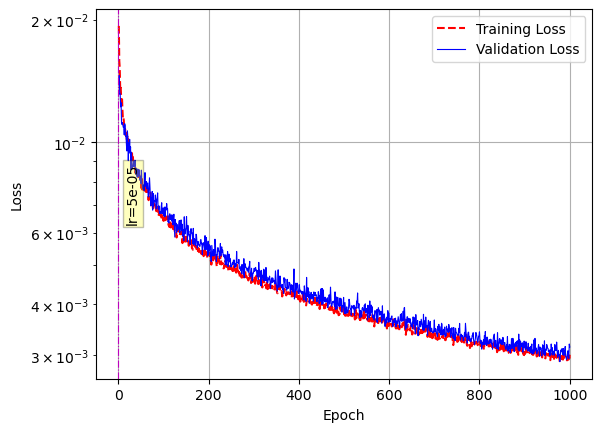

<Figure size 640x480 with 0 Axes>

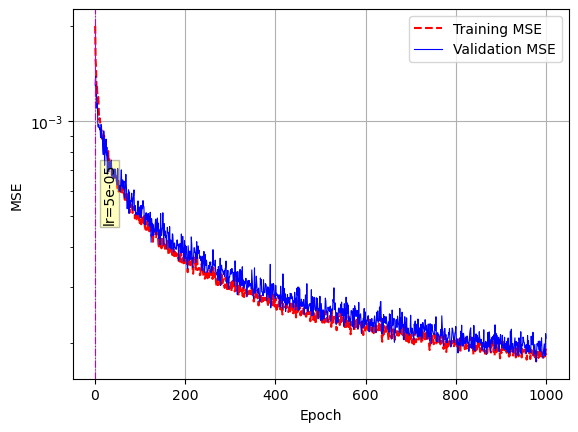

<Figure size 640x480 with 0 Axes>

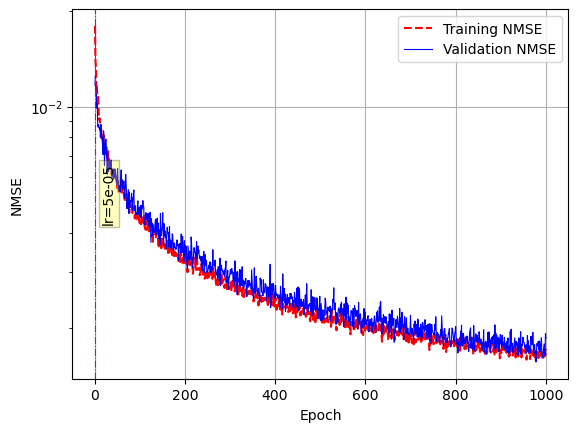

<Figure size 640x480 with 0 Axes>

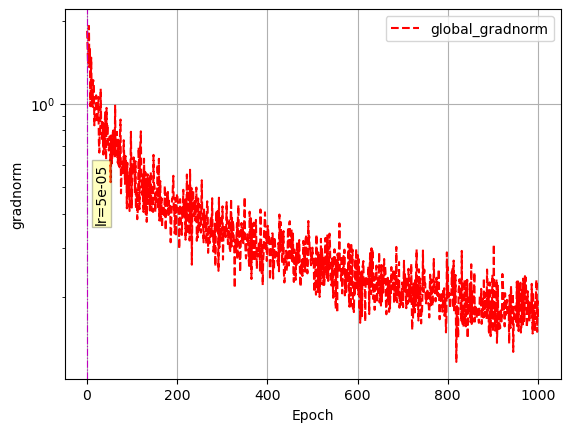



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 15 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 2.0


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
67/67 [==============================] - ETA: 0s - loss: 0.0048 - mse: 4.5495e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.3491e-04 - global_gradnorm: 0.2731 - tot_time: 0h 1m 15.1s

Epoch 1: val_NMSE improved from inf to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/check

67/67 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.0221e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.9638e-04 - global_gradnorm: 0.2467 - tot_time: 0h 5m 30.5s

Epoch 11: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 380ms/step - loss: 0.0044 - mse: 4.0221e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.9618e-04 - global_gradnorm: 0.2467 - val_loss: 0.0035 - val_mse: 2.7309e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
67/67 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.0402e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.9935e-04 - global_gradnorm: 0.2560 - tot_time: 0h 5m 55.6s

Epoch 12: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/

Epoch 23/1000
67/67 [==============================] - ETA: 0s - loss: 0.0044 - mse: 3.9835e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.9180e-04 - global_gradnorm: 0.2464 - tot_time: 0h 10m 31.5s

Epoch 23: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 372ms/step - loss: 0.0044 - mse: 3.9835e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.9158e-04 - global_gradnorm: 0.2461 - val_loss: 0.0034 - val_mse: 2.6236e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
67/67 [==============================] - ETA: 0s - loss: 0.0043 - mse: 3.9000e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.9061e-04 - global_gradnorm: 0.2464 - tot_time: 0h 10m 56.5s

Epoch 24: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0043 - mse: 3.8635e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.8604e-04 - global_gradnorm: 0.2422 - tot_time: 0h 15m 30.9s

Epoch 35: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 374ms/step - loss: 0.0043 - mse: 3.8635e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.8645e-04 - global_gradnorm: 0.2427 - val_loss: 0.0034 - val_mse: 2.5753e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
67/67 [==============================] - ETA: 0s - loss: 0.0043 - mse: 3.8382e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.8448e-04 - global_gradnorm: 0.2515 - tot_time: 0h 15m 56.0s

Epoch 36: val_NMSE improved from 0.00219 to 0.00219, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/check

Epoch 47/1000
67/67 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.7505e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.7788e-04 - global_gradnorm: 0.2393 - tot_time: 0h 20m 32.7s

Epoch 47: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 378ms/step - loss: 0.0042 - mse: 3.7505e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.7790e-04 - global_gradnorm: 0.2391 - val_loss: 0.0033 - val_mse: 2.4753e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
67/67 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.7536e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.7810e-04 - global_gradnorm: 0.2438 - tot_time: 0h 20m 57.5s

Epoch 48: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 59/1000
67/67 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.7278e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.7655e-04 - global_gradnorm: 0.2516 - tot_time: 0h 25m 32.9s

Epoch 59: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 373ms/step - loss: 0.0042 - mse: 3.7278e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.7677e-04 - global_gradnorm: 0.2519 - val_loss: 0.0034 - val_mse: 2.4935e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
67/67 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.7709e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.7801e-04 - global_gradnorm: 0.2430 - tot_time: 0h 25m 58.0s

Epoch 60: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0042 - mse: 3.6565e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.7230e-04 - global_gradnorm: 0.2418 - tot_time: 0h 30m 33.5s

Epoch 71: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 371ms/step - loss: 0.0042 - mse: 3.6565e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.7218e-04 - global_gradnorm: 0.2428 - val_loss: 0.0034 - val_mse: 2.5153e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.6058e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6973e-04 - global_gradnorm: 0.2386 - tot_time: 0h 30m 58.5s

Epoch 72: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.6323e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.6824e-04 - global_gradnorm: 0.2337 - tot_time: 0h 35m 33.6s

Epoch 83: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 370ms/step - loss: 0.0041 - mse: 3.6323e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.6851e-04 - global_gradnorm: 0.2337 - val_loss: 0.0033 - val_mse: 2.4649e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.5514e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6601e-04 - global_gradnorm: 0.2335 - tot_time: 0h 35m 58.7s

Epoch 84: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 95/1000
67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.5867e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6620e-04 - global_gradnorm: 0.2380 - tot_time: 0h 40m 34.1s

Epoch 95: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 370ms/step - loss: 0.0041 - mse: 3.5867e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6625e-04 - global_gradnorm: 0.2390 - val_loss: 0.0034 - val_mse: 2.5056e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.5796e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6650e-04 - global_gradnorm: 0.2417 - tot_time: 0h 40m 59.5s

Epoch 96: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.5262e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6484e-04 - global_gradnorm: 0.2385 - tot_time: 0h 45m 35.2s

Epoch 107: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 374ms/step - loss: 0.0041 - mse: 3.5262e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6515e-04 - global_gradnorm: 0.2393 - val_loss: 0.0034 - val_mse: 2.5046e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.5380e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6355e-04 - global_gradnorm: 0.2434 - tot_time: 0h 46m 0.2s

Epoch 108: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

67/67 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.5238e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6263e-04 - global_gradnorm: 0.2379 - tot_time: 0h 50m 37.3s

Epoch 119: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 375ms/step - loss: 0.0041 - mse: 3.5238e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.6320e-04 - global_gradnorm: 0.2386 - val_loss: 0.0034 - val_mse: 2.5357e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 120/1000
67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.4385e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5846e-04 - global_gradnorm: 0.2271 - tot_time: 0h 51m 2.6s

Epoch 120: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 131/1000
67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.4491e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5910e-04 - global_gradnorm: 0.2341 - tot_time: 0h 55m 38.7s

Epoch 131: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 377ms/step - loss: 0.0040 - mse: 3.4491e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5891e-04 - global_gradnorm: 0.2343 - val_loss: 0.0033 - val_mse: 2.4769e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 132/1000
67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.4604e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5671e-04 - global_gradnorm: 0.2253 - tot_time: 0h 56m 4.0s

Epoch 132: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.4347e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5734e-04 - global_gradnorm: 0.2397 - tot_time: 1h 0m 40.9s

Epoch 143: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 383ms/step - loss: 0.0040 - mse: 3.4347e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5713e-04 - global_gradnorm: 0.2404 - val_loss: 0.0033 - val_mse: 2.3831e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 144/1000
67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.4339e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5724e-04 - global_gradnorm: 0.2325 - tot_time: 1h 1m 6.4s

Epoch 144: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.3698e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5327e-04 - global_gradnorm: 0.2399 - tot_time: 1h 5m 44.1s

Epoch 155: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 381ms/step - loss: 0.0040 - mse: 3.3698e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5313e-04 - global_gradnorm: 0.2398 - val_loss: 0.0033 - val_mse: 2.4187e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 156/1000
67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.3600e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5121e-04 - global_gradnorm: 0.2307 - tot_time: 1h 6m 9.4s

Epoch 156: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.3580e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5326e-04 - global_gradnorm: 0.2361 - tot_time: 1h 10m 45.8s

Epoch 167: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 378ms/step - loss: 0.0040 - mse: 3.3580e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5322e-04 - global_gradnorm: 0.2359 - val_loss: 0.0033 - val_mse: 2.4340e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 168/1000
67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.4055e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.5514e-04 - global_gradnorm: 0.2348 - tot_time: 1h 11m 10.9s

Epoch 168: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

67/67 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.3583e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5239e-04 - global_gradnorm: 0.2339 - tot_time: 1h 15m 48.8s

Epoch 179: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 378ms/step - loss: 0.0040 - mse: 3.3583e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5240e-04 - global_gradnorm: 0.2339 - val_loss: 0.0033 - val_mse: 2.4333e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 180/1000
67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.3093e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.4828e-04 - global_gradnorm: 0.2298 - tot_time: 1h 16m 13.7s

Epoch 180: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.2456e-04 - NMSE: 0.0029 - covmat_fro_loss: 4.4479e-04 - global_gradnorm: 0.2226 - tot_time: 1h 20m 50.5s

Epoch 191: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 375ms/step - loss: 0.0039 - mse: 3.2456e-04 - NMSE: 0.0029 - covmat_fro_loss: 4.4472e-04 - global_gradnorm: 0.2224 - val_loss: 0.0033 - val_mse: 2.4486e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 192/1000
67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.2953e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.4781e-04 - global_gradnorm: 0.2286 - tot_time: 1h 21m 15.9s

Epoch 192: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.2964e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.4739e-04 - global_gradnorm: 0.2329 - tot_time: 1h 25m 52.5s

Epoch 203: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 375ms/step - loss: 0.0039 - mse: 3.2964e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.4784e-04 - global_gradnorm: 0.2333 - val_loss: 0.0033 - val_mse: 2.4581e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 204/1000
67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.3132e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.4872e-04 - global_gradnorm: 0.2315 - tot_time: 1h 26m 17.5s

Epoch 204: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.3163e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5129e-04 - global_gradnorm: 0.2368 - tot_time: 1h 30m 54.7s

Epoch 215: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 381ms/step - loss: 0.0039 - mse: 3.3163e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.5129e-04 - global_gradnorm: 0.2367 - val_loss: 0.0033 - val_mse: 2.3715e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 216/1000
67/67 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.2460e-04 - NMSE: 0.0029 - covmat_fro_loss: 4.4501e-04 - global_gradnorm: 0.2358 - tot_time: 1h 31m 20.1s

Epoch 216: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

<Figure size 640x480 with 0 Axes>

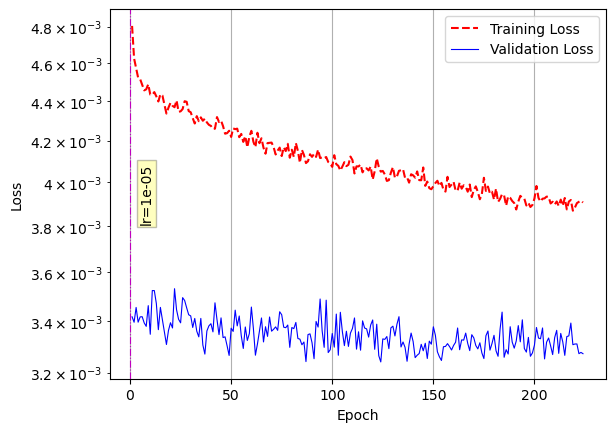

<Figure size 640x480 with 0 Axes>

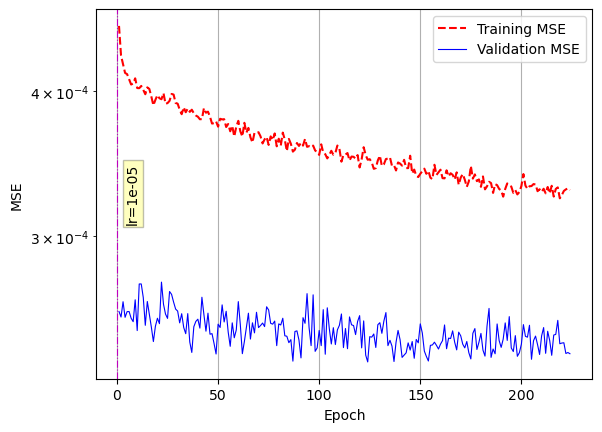

<Figure size 640x480 with 0 Axes>

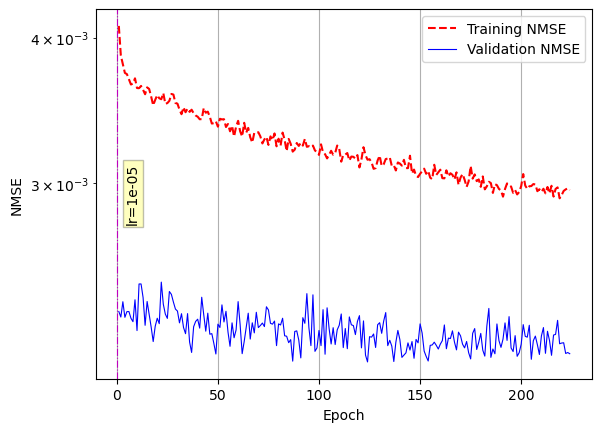

<Figure size 640x480 with 0 Axes>

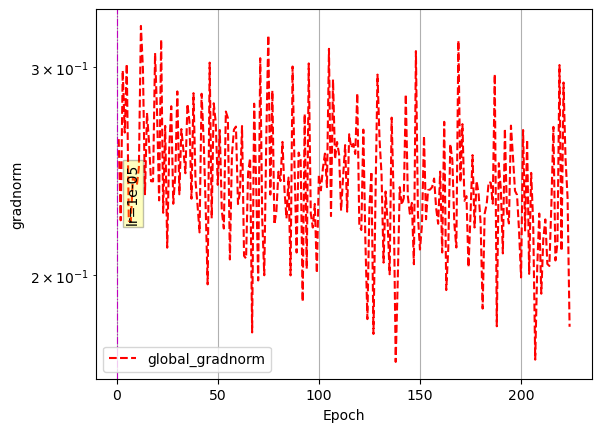



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 20 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.25


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
64/64 [==============================] - ETA: 0s - loss: 0.0073 - mse: 8.6824e-04 - NMSE: 0.0078 - covmat_fro_loss: 8.0892e-04 - global_gradnorm: 0.2500 - tot_time: 0h 1m 32.4s

Epoch 1: val_NMSE improved from inf to 0.00421, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/checkpoint-20_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/chec

64/64 [==============================] - ETA: 0s - loss: 0.0068 - mse: 7.8188e-04 - NMSE: 0.0070 - covmat_fro_loss: 7.7841e-04 - global_gradnorm: 0.2500 - tot_time: 0h 6m 24.1s

Epoch 12: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 410ms/step - loss: 0.0068 - mse: 7.8188e-04 - NMSE: 0.0070 - covmat_fro_loss: 7.7743e-04 - global_gradnorm: 0.2500 - val_loss: 0.0055 - val_mse: 5.7829e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
64/64 [==============================] - ETA: 0s - loss: 0.0069 - mse: 7.9801e-04 - NMSE: 0.0072 - covmat_fro_loss: 7.8093e-04 - global_gradnorm: 0.2500 - tot_time: 0h 6m 50.7s

Epoch 13: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/

64/64 [==============================] - ETA: 0s - loss: 0.0068 - mse: 7.8725e-04 - NMSE: 0.0071 - covmat_fro_loss: 7.7843e-04 - global_gradnorm: 0.2500 - tot_time: 0h 11m 39.9s

Epoch 24: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 27s 420ms/step - loss: 0.0068 - mse: 7.8725e-04 - NMSE: 0.0071 - covmat_fro_loss: 7.7763e-04 - global_gradnorm: 0.2500 - val_loss: 0.0056 - val_mse: 5.9459e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
64/64 [==============================] - ETA: 0s - loss: 0.0068 - mse: 7.8818e-04 - NMSE: 0.0071 - covmat_fro_loss: 7.7935e-04 - global_gradnorm: 0.2500 - tot_time: 0h 12m 6.2s

Epoch 25: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013

64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.6983e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.7006e-04 - global_gradnorm: 0.2500 - tot_time: 0h 16m 57.0s

Epoch 36: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 412ms/step - loss: 0.0067 - mse: 7.6983e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.7007e-04 - global_gradnorm: 0.2500 - val_loss: 0.0055 - val_mse: 5.8809e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.7626e-04 - NMSE: 0.0070 - covmat_fro_loss: 7.7673e-04 - global_gradnorm: 0.2500 - tot_time: 0h 17m 23.6s

Epoch 37: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.7236e-04 - NMSE: 0.0070 - covmat_fro_loss: 7.7142e-04 - global_gradnorm: 0.2500 - tot_time: 0h 22m 11.6s

Epoch 48: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 402ms/step - loss: 0.0067 - mse: 7.7236e-04 - NMSE: 0.0070 - covmat_fro_loss: 7.7191e-04 - global_gradnorm: 0.2500 - val_loss: 0.0055 - val_mse: 5.8022e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.6706e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.6933e-04 - global_gradnorm: 0.2498 - tot_time: 0h 22m 38.1s

Epoch 49: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

64/64 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.6059e-04 - NMSE: 0.0068 - covmat_fro_loss: 7.6605e-04 - global_gradnorm: 0.2500 - tot_time: 0h 27m 28.5s

Epoch 60: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 412ms/step - loss: 0.0066 - mse: 7.6059e-04 - NMSE: 0.0068 - covmat_fro_loss: 7.6706e-04 - global_gradnorm: 0.2500 - val_loss: 0.0057 - val_mse: 6.0913e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.6961e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.6952e-04 - global_gradnorm: 0.2500 - tot_time: 0h 27m 54.8s

Epoch 61: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

64/64 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.5955e-04 - NMSE: 0.0068 - covmat_fro_loss: 7.6706e-04 - global_gradnorm: 0.2500 - tot_time: 0h 32m 43.2s

Epoch 72: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 404ms/step - loss: 0.0066 - mse: 7.5955e-04 - NMSE: 0.0068 - covmat_fro_loss: 7.6748e-04 - global_gradnorm: 0.2500 - val_loss: 0.0055 - val_mse: 5.8769e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.6531e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.6641e-04 - global_gradnorm: 0.2500 - tot_time: 0h 33m 8.9s

Epoch 73: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013

64/64 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.6549e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.6791e-04 - global_gradnorm: 0.2500 - tot_time: 0h 37m 55.7s

Epoch 84: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 407ms/step - loss: 0.0067 - mse: 7.6549e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.6913e-04 - global_gradnorm: 0.2500 - val_loss: 0.0056 - val_mse: 5.9592e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
64/64 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.5317e-04 - NMSE: 0.0068 - covmat_fro_loss: 7.6245e-04 - global_gradnorm: 0.2500 - tot_time: 0h 38m 21.9s

Epoch 85: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

64/64 [==============================] - ETA: 0s - loss: 0.0065 - mse: 7.4099e-04 - NMSE: 0.0067 - covmat_fro_loss: 7.5863e-04 - global_gradnorm: 0.2500 - tot_time: 0h 43m 8.3s

Epoch 96: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 409ms/step - loss: 0.0065 - mse: 7.4099e-04 - NMSE: 0.0067 - covmat_fro_loss: 7.5956e-04 - global_gradnorm: 0.2500 - val_loss: 0.0055 - val_mse: 5.8772e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 97/1000
64/64 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.5200e-04 - NMSE: 0.0068 - covmat_fro_loss: 7.6109e-04 - global_gradnorm: 0.2500 - tot_time: 0h 43m 34.0s

Epoch 97: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_013

<Figure size 640x480 with 0 Axes>

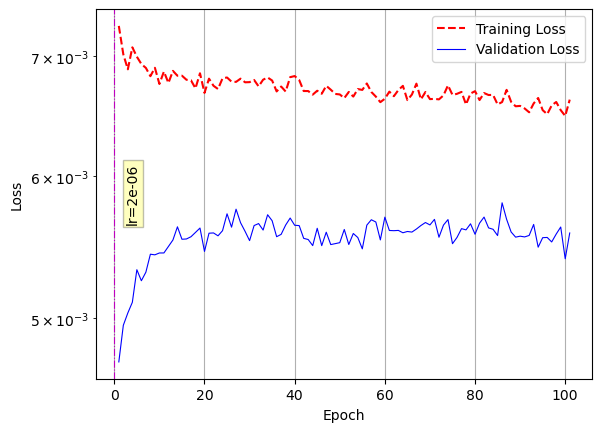

<Figure size 640x480 with 0 Axes>

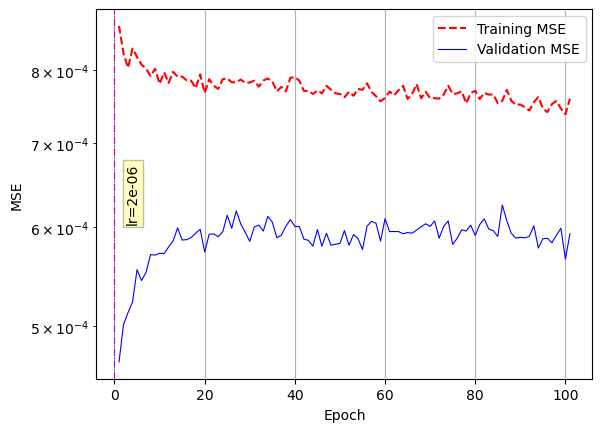

<Figure size 640x480 with 0 Axes>

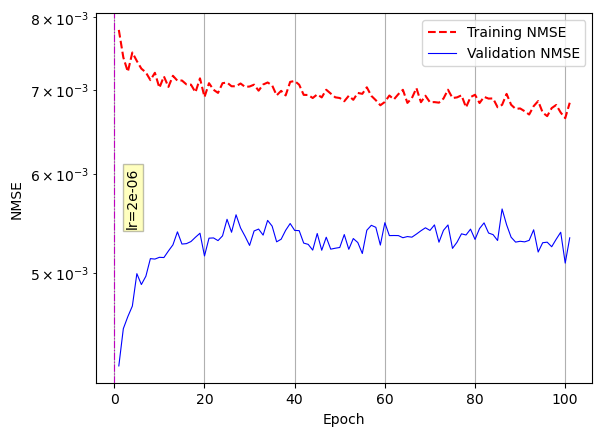

<Figure size 640x480 with 0 Axes>

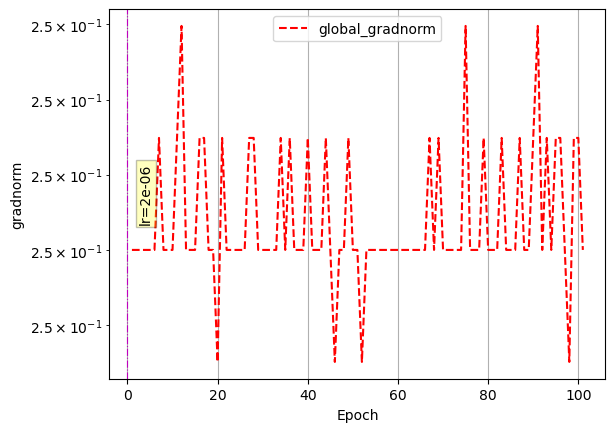

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_GRU,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [22]:
### Training the combined AE-RNN


# 